In [1]:
import sys, os, time, copy, gc
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
import torchvision

import numpy as np
import pandas as pd

import warnings

sys.path.append('../src')
from train import *
from models import *
from dataset import *
from pre_processing import *



## Configure the training run

In [2]:
 # Unet defined in models.py
CONFIG ={   
    "model" : 'UNet',
    "dataset" : 'CIFAR10',
    "epochs": 100,
    "train_batch_size": 50,
    "valid_batch_size": 50,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "scheduler": None,
    "model_params" : {
        "in_channels": 1,
        "out_channels": 3,
    },
    "scheduler_params" : {
        "T_max": 10,
        "min_lr": 1e-4
    },
    "device" : 'cuda',
    "loss" : 'MSE',
    "IN_COLORMAP" : 'GRAY',
    "OUT_COLORMAP" : 'RGB',
    "display_loss_epoch" : 5
}

## Initializing the Device

In [3]:
if "device" not in CONFIG.keys():
    CONFIG["device"] = 'cpu' 
    print(f"Device was not specified in config. Using device: {CONFIG['device']}")
elif CONFIG["device"] == 'cuda' and torch.cuda.is_available():
    device = torch.device(CONFIG['device'])
    print(f"Using device: {device}")
else:
    CONFIG["device"] = 'cpu' 
    print(f"Using device: {CONFIG['device']}")

Using device: cuda


## Preparing the Data

In [4]:
data_path = Path('../datasets')
coco_path = data_path/'coco'

In [5]:
if "dataset" not in CONFIG.keys() or CONFIG["dataset"] not in ['CIFAR10', 'COCO']:
    warnings.warn("Please specify a valid dataset in the config")

elif CONFIG["dataset"] == 'COCO':
    print("Using COCO dataset")
    coco_train_dataset = torchvision.datasets.CocoDetection(coco_path/'train2017', transform=None)
    coco_val_dataset = torchvision.datasets.CocoDetection(coco_path/'val2017', transform=None)
elif CONFIG["dataset"] == 'CIFAR10' :
    print("Using CIFAR10 dataset")
    cifar_train_dataset = torchvision.datasets.CIFAR10(data_path, train=True, transform=None)
    cifar_val_dataset = torchvision.datasets.CIFAR10(data_path, train=False, transform=None)

Using CIFAR10 dataset


In [6]:
transform_in = getTransform_in(CONFIG)
transform_out = getTransform_out(CONFIG)


In [7]:
train_dataset = BuildImageDataset(cifar_train_dataset, transform_in=transform_in, transform_out=transform_out)
valid_dataset = BuildImageDataset(cifar_val_dataset, transform_in=transform_in, transform_out=transform_out)

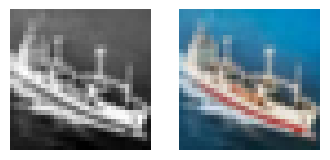

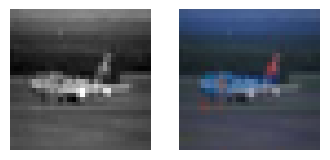

In [8]:
idx_train = np.random.randint(0, len(train_dataset))
idx_valid = np.random.randint(0, len(valid_dataset))
#Display random image from train dataset
train_dataset.display_img_pair(idx = idx_train,upscaling_factor=4)
#Display random image from train dataset
valid_dataset.display_img_pair(idx = idx_valid,upscaling_factor=4)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], shuffle=False,pin_memory=True)

In [9]:
model = setup_model(CONFIG)
display_trainable_params(model)

Generating summary for model with input size 32x32
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]     

7701955

## Run the Training

In [10]:
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer, CONFIG)

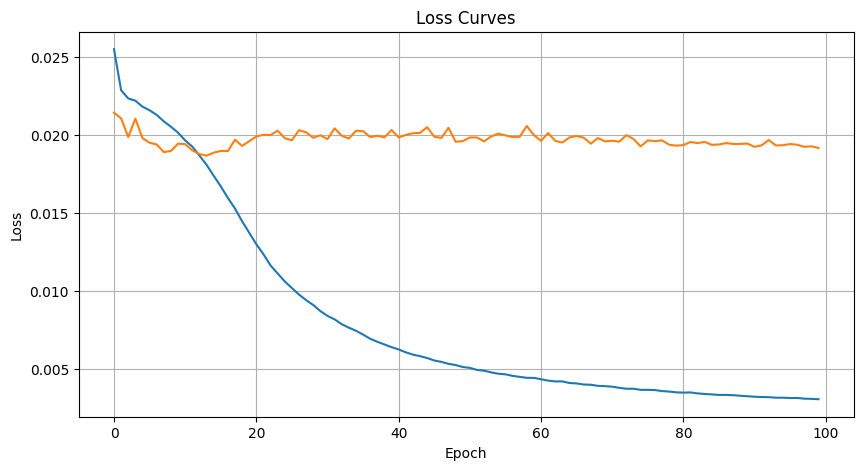

Epoch [100/100], Train Loss: 0.0031, Validation Loss: 0.0192, LR: 0.001000
Training complete in 1h 15m 8s


In [11]:
model_out, train_loss,valid_loss, lr_rate = train_model(
    train_loader= train_dataloader,
    valid_loader= valid_dataloader,
    model= model,
    optimizer= optimizer,
    scheduler= scheduler,
    CONFIG= CONFIG)

## Save the model checkpoint

In [13]:
checkpoint = {
    'model': model_out,
    'state_dict': model_out.state_dict(),
    'optimizer': optimizer.state_dict(),
    #'scheduler': scheduler.state_dict(),
    'CONFIG': CONFIG,
    'train_loss': train_loss,
    'valid_loss': valid_loss,
    'lr_rate': lr_rate
}
#not using hash_config for now
def hash_config(config):
    import hashlib
    return hashlib.md5(str(config).encode()).hexdigest()
#get date and time
now = time.localtime()
if not os.path.exists(f'../models/{CONFIG["model"]}_{time.strftime("%Y-%m-%d_%H_%M", now)}.pth'):
    torch.save(checkpoint, f'../models/{CONFIG["model"]}_{time.strftime("%Y-%m-%d_%H_%M", now)}.pth')
    print("Model saved")
else:
    print("Model name already exists")
    print(f'../models/{CONFIG["model"]}_{time.strftime("%Y-%m-%d_%H_%M", now)}.pth')

Model saved
